# Transformer from Scratch: English to Tamil Translation

This notebook builds a Transformer model from scratch to translate sentences from **English to Tamil**. It is inspired by the *Attention is All You Need* paper.

## Step 0: Basic Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.checkpoint import checkpoint

# Set device to GPU if available for faster training, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.backends.cudnn.benchmark = True

import warnings
warnings.filterwarnings('ignore')

Using device: cuda


## Step 1: Multi-Head Attention

Transformers are a very exciting family of ML architectures. The basis of transformer is attention.

What is Attention?

So, lets imagine we have a sentence like “The cat sat on the mat.”

When processing the word “sat,” our brain naturally looks back at “cat” to understand **who** did the action. Attention is also the same thing.

So, in self-attention:

- Every word in the sentence takes a look at all the other words, including itself.
- Then it asks: “Which of these words matter most to me?”
- Based on that relevance, the word collects a little bit from each of the others, giving more weight to the important ones, and less to the unimportant ones.
- After mixing, it forms a new version of itself and now aware of the context around it.

We hvae three Vectors in Attention: Q, K, V.

For each word vector \( x_i \), we create three vectors:
- **Q (Query)**: What am I looking for?
- **K (Key)**: What do I contain?
- **V (Value)**: What info do I provide?


These are just **linear transformations/Matrix Multiplication** of the input.

Then, we calculate how well each **Query** matches **Keys** using dot product.
Because dot products get bigger in higher dimensions — so dividing keeps the values stable for the softmax.


Then, we apply `softmax` to turn those scores into **probabilities**. Now each word knows **how much to pay attention** to every other word.

Then we calculate the weighted Sum of Values.

---

What is Multi-Head Attention?

So, a single attention head is looking at the sentence from **one perspective**.

But any language has a lot of other perspectives like grammer, semantics, sentiments, etc. So instead of just one attention operation, we do **multiple in parallel**, each with its own Q, K, V.

That’s what your code is doing with:

```python
Q, K, V = map(split_heads, (Q, K, V))
```

Each head gets a **smaller piece of the full vector space** (e.g., 512 model dim split into 8 heads → 64 dim each).

After computing attention for each head, we bring the heads back together.

---

This `MultiHeadAttention` module is one block inside a **Transformer** model. In a full model:
- we have this attention layer
- Followed by feedforward layers
- Add LayerNorm and skip connections


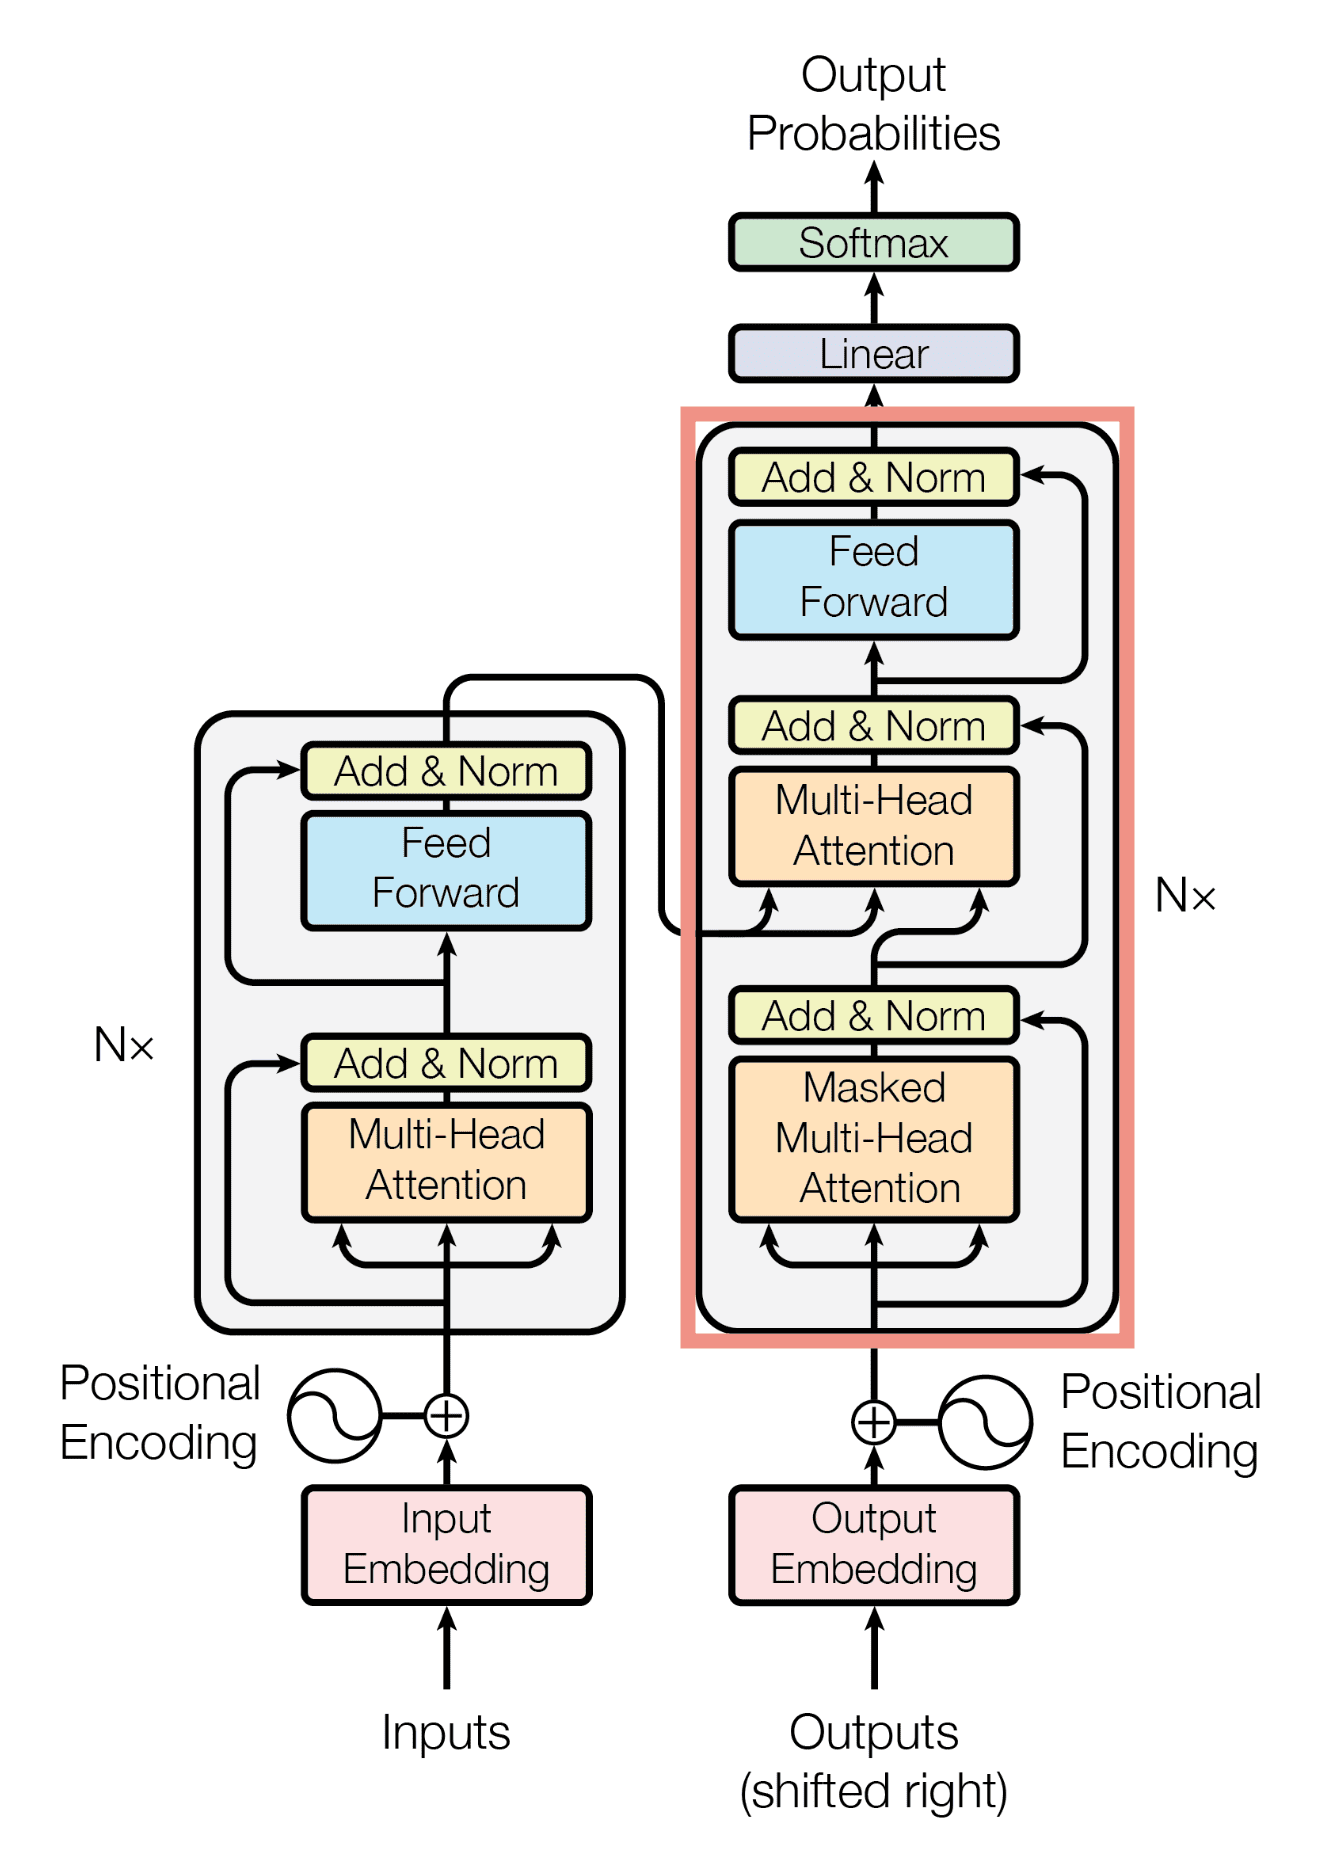

In [2]:

class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention allows the model to jointly attend to information
    from different representation subspaces (different 'heads').

    Each head performs scaled dot-product attention separately,
    and the results are concatenated and transformed.
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out_linear = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.q_linear(query)
        K = self.k_linear(key)
        V = self.v_linear(value)

        def split_heads(x):
            return x.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        Q, K, V = map(split_heads, (Q, K, V))

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        output = torch.matmul(attn, V)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.out_linear(output)


## Step 2: Encoder Layer

 A single layer in the Encoder.

 Each encoder layer has:
- Multi-head self-attention (each word attends to every other word in input)
- Feedforward network
- Layer normalization and residual connections


In [3]:

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention + Add & Norm
        x = self.norm1(x + self.dropout1(self.self_attn(x, x, x, mask)))
        # Feedforward + Add & Norm
        x = self.norm2(x + self.dropout2(self.feed_forward(x)))
        return x


## Step 3: Decoder Layer

A single layer in the Decoder.

It has 3 parts:
- Masked multi-head self-attention (can’t look ahead in output)
- Encoder-decoder attention (attend to encoder outputs)
- Feedforward network
- Layer normalization and residuals for all 3 sublayers

In [4]:

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask=None, src_mask=None):
        x = self.norm1(x + self.dropout1(self.self_attn(x, x, x, tgt_mask)))
        x = self.norm2(x + self.dropout2(self.enc_dec_attn(x, enc_output, enc_output, src_mask)))
        x = self.norm3(x + self.dropout3(self.feed_forward(x)))
        return x



## Step 4: Positional Encoding

Transformer has no built-in recurrence or order awareness.
This module adds positional signals to word embeddings so the model knows the word positions.

It uses sine and cosine functions at different frequencies.
This method is fixed and doesn't require learning position embeddings.

In [5]:

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even positions, cosine to odd positions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)



## Step 5: Encoder Stack


Full Encoder made by stacking multiple EncoderLayers.

It also includes:
- Word embeddings (learned lookup table for each token)
- Positional encoding (to retain word order info)

In [6]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, ff_hidden_dim, max_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, mask=None):
        x = self.embedding(src)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = checkpoint(layer, x, mask, use_reentrant=False)
        return x

## Step 6: Decoder Stack


Full Decoder made by stacking multiple DecoderLayers.

Similar to Encoder, it also has:
- Embedding layer
- Positional encoding
- Dropout

In [7]:

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, ff_hidden_dim, max_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_hidden_dim, dropout) for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, enc_output, tgt_mask=None, src_mask=None):
        x = self.embedding(tgt)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = checkpoint(layer, x, enc_output, tgt_mask, src_mask, use_reentrant=False)
        return x

## Step 7: Full Transformer Model

Combines Encoder and Decoder into a single model.
    
This is the full Transformer architecture that takes in source and target tokens,
runs them through the Encoder and Decoder stacks, and finally outputs logits for each word.

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, ff_hidden_dim, max_len, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, ff_hidden_dim, max_len, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, ff_hidden_dim, max_len, dropout)
        self.final_linear = nn.Linear(d_model, tgt_vocab_size)  # map decoder output to vocab size

    def make_subsequent_mask(self, size):
        # Prevents decoder from attending to future tokens (causal mask)
        mask = torch.tril(torch.ones(size, size)).unsqueeze(0).unsqueeze(0)
        return mask

    def forward(self, src, tgt):
        src_mask = None
        tgt_mask = self.make_subsequent_mask(tgt.size(1)).to(tgt.device)
        enc_output = self.encoder(src, src_mask)
        dec_output = self.decoder(tgt, enc_output, tgt_mask, src_mask)
        return self.final_linear(dec_output)



## Step 8: Loading the Dataset

We are using English to Tamil Dataset. The link for the same is-

https://github.com/nlpcuom/English-Tamil-Parallel-Corpus

https://github.com/Ishikahooda/Tamil-English-Dataset/tree/master

https://data.statmt.org/pmindia/v1/parallel/

In [9]:
import os
import csv
import sys

base_dir = "English-Tamil-Parallel-Corpus-master/En-Ta Corpus"
en_file = os.path.join(base_dir, "En-Ta English.txt")
ta_file = os.path.join(base_dir, "En-Ta Tamil.txt")

with open(en_file, encoding="utf-8") as f_en, open(ta_file, encoding="utf-8") as f_ta:
    english_sentences_1 = [line.strip() for line in f_en]
    tamil_sentences_1 = [line.strip() for line in f_ta]

# Remove empty lines and ensure alignment
pairs_1 = [(en, ta) for en, ta in zip(english_sentences_1, tamil_sentences_1) if en and ta]
english_sentences_1, tamil_sentences_1 = zip(*pairs_1)

csv.field_size_limit(2**31-1)

pmindia_file = "English-Tamil-Parallel-Corpus-master/pmindia.v1.ta-en.tsv"
english_sentences_2 = []
tamil_sentences_2 = []

with open(pmindia_file, encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        if len(row) == 2:
            ta, en = row
            ta, en = ta.strip(), en.strip()
            if ta and en:
                tamil_sentences_2.append(ta)
                english_sentences_2.append(en)

english_sentences = list(english_sentences_1) + english_sentences_2
tamil_sentences = list(tamil_sentences_1) + tamil_sentences_2

pairs = list(set(zip(english_sentences, tamil_sentences)))
english_sentences, tamil_sentences = zip(*pairs)

MAX_LENGTH = 100
filtered_pairs = [
    (en, ta)
    for en, ta in zip(english_sentences, tamil_sentences)
    if len(en.split()) <= MAX_LENGTH and len(ta.split()) <= MAX_LENGTH
]
english_sentences, tamil_sentences = zip(*filtered_pairs)

dataset_folder = "English-Tamil-Parallel-Corpus-master/Dataset"

english_sentences_new = []
tamil_sentences_new = []

for i in range(1, 7):
    en_path = os.path.join(dataset_folder, f"data.en{i}")
    ta_path = os.path.join(dataset_folder, f"data.ta{i}")
    if os.path.exists(en_path) and os.path.exists(ta_path):
        with open(en_path, encoding="utf-8") as f_en, open(ta_path, encoding="utf-8") as f_ta:
            en_lines = [line.strip() for line in f_en]
            ta_lines = [line.strip() for line in f_ta]
            # Ensure alignment and remove empty pairs
            pairs = [(en, ta) for en, ta in zip(en_lines, ta_lines) if en and ta]
            english_sentences_new.extend([en for en, ta in pairs])
            tamil_sentences_new.extend([ta for en, ta in pairs])
    else:
        print(f"Missing file: {en_path} or {ta_path}")

print(f"Loaded {len(english_sentences_new)} parallel pairs from the new dataset.")

# Now combine with your previous datasets
english_sentences = list(english_sentences) + english_sentences_new
tamil_sentences = list(tamil_sentences) + tamil_sentences_new

pairs = list(set(zip(english_sentences, tamil_sentences)))
english_sentences, tamil_sentences = zip(*pairs)

MAX_LENGTH = 100
filtered_pairs = [
    (en, ta)
    for en, ta in zip(english_sentences, tamil_sentences)
    if len(en.split()) <= MAX_LENGTH and len(ta.split()) <= MAX_LENGTH
]
english_sentences, tamil_sentences = zip(*filtered_pairs)

train_en, val_en, train_ta, val_ta = train_test_split(
    english_sentences, tamil_sentences, test_size=0.1, random_state=42
)

print(f"First dataset pairs: {len(pairs_1)}")
print(f"Second dataset pairs: {len(english_sentences_2)}")
print(f"Total combined pairs (after deduplication/cleaning): {len(english_sentences)}")
print(f"Train pairs: {len(train_en)}")
print(f"Validation pairs: {len(val_en)}")

Loaded 289451 parallel pairs from the new dataset.
First dataset pairs: 8902
Second dataset pairs: 20040
Total combined pairs (after deduplication/cleaning): 315902
Train pairs: 284311
Validation pairs: 31591


## Step 9: Tokenizer (Word-level)

We want a way to convert sentences made of words into numbers, so we can give them to our transformers. Transformers can’t understand words directly — they need numbers.

So, this will create a dictionary of words and assigns each word a unique number (ID).
And it will encode a sentence into a list of numbers (token IDs). And then later can decode token IDs back into a sentence of words.

In [10]:

class SimpleTokenizer:
    def __init__(self, sentences, min_freq=1):
        # Initialize dictionaries for word-to-index and index-to-word mappings
        self.word2idx = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        self.idx2word = {0: '<pad>', 1: '<sos>', 2: '<eos>', 3: '<unk>'}
        self.word_freq = {}

        # Count word frequencies across all sentences
        for sentence in sentences:
            for word in sentence.lower().split():
                self.word_freq[word] = self.word_freq.get(word, 0) + 1

        # Only include words that meet the minimum frequency threshold
        for word, freq in self.word_freq.items():
            if freq >= min_freq:
                index = len(self.word2idx)
                self.word2idx[word] = index
                self.idx2word[index] = word

    def encode(self, sentence):
        """Converts a sentence into a list of token ids. Unknown words are mapped to <unk>."""
        return [self.word2idx.get(word, self.word2idx['<unk>']) for word in sentence.lower().split()]

    def decode(self, indices):
        """Converts token ids back to a sentence."""
        return ' '.join(self.idx2word.get(idx, '<unk>') for idx in indices)

    def __len__(self):
        return len(self.word2idx)

en_tokenizer = SimpleTokenizer(train_en)
fr_tokenizer = SimpleTokenizer(train_ta)


## Step 10: Dataset and Dataloader

Here, we are creating a custom dataset to help train a model to translate from English to French.

It helps prepare the data in a way that a model can understand and learn from — with inputs and outputs all nicely formatted and of equal length.

In [11]:
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences, source_tokenizer, target_tokenizer, max_len=20):
        self.src = source_sentences
        self.trg = target_sentences
        self.src_tokenizer = source_tokenizer
        self.trg_tokenizer = target_tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        # Convert each sentence to token ids
        src_ids = self.src_tokenizer.encode(self.src[idx])
        trg_ids = self.trg_tokenizer.encode(self.trg[idx])

        # Prepare decoder input by adding <sos> token at the beginning
        trg_input = [1] + trg_ids
        # Prepare decoder output by adding <eos> token at the end
        trg_output = trg_ids + [2]

        src_ids = src_ids[:self.max_len] + [0] * (self.max_len - len(src_ids))
        trg_input = trg_input[:self.max_len] + [0] * (self.max_len - len(trg_input))
        trg_output = trg_output[:self.max_len] + [0] * (self.max_len - len(trg_output))

        return torch.tensor(src_ids), torch.tensor(trg_input), torch.tensor(trg_output)

# Initialize training dataset and wrap in DataLoader
# DataLoader gives batches of (src, trg_input, trg_output) during training
train_dataset = TranslationDataset(train_en, train_ta, en_tokenizer, fr_tokenizer)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

val_dataset = TranslationDataset(val_en, val_ta, en_tokenizer, fr_tokenizer)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0, pin_memory=True)



## Step 11: Training Setup — Loss, Optimizer, Training Loop

Here we are defining everything needed to train our Transformer model, evaluate it on validation data, and plot how well it’s learning.

In [12]:
import matplotlib.pyplot as plt
from tqdm import tqdm
loss_fn = nn.CrossEntropyLoss(ignore_index=0)
accumulation_steps = 2 
# using Adam optimizer
def get_optimizer(model, lr=1e-4):
    return torch.optim.AdamW(model.parameters(), lr=lr)

def train(model, train_loader, val_loader, optimizer, loss_fn, tokenizer, num_epochs=10, save_path="transformer_weights.pth"):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [] , []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train, total_train_tokens = 0, 0
        
        optimizer.zero_grad()
        
        with tqdm(train_loader, desc=f"Epoch {epoch+1}") as pbar:
            for batch_idx, (src, tgt_input, tgt_output) in enumerate(pbar):
                src, tgt_input, tgt_output = src.to(device), tgt_input.to(device), tgt_output.to(device)
                output = model(src, tgt_input)
                output = output.view(-1, output.size(-1))
                tgt_output = tgt_output.view(-1)
                loss = loss_fn(output, tgt_output)
                loss = loss / accumulation_steps  # Normalize loss by accumulation steps
                loss.backward()
                if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                    optimizer.step()
                    optimizer.zero_grad()
                total_train_loss += loss.item() * accumulation_steps

                preds = torch.argmax(output, dim=1)
                mask = tgt_output != 0
                correct_train += (preds == tgt_output)[mask].sum().item()
                total_train_tokens += mask.sum().item()
                if batch_idx % 10 == 0:
                    pbar.set_postfix(loss=loss.item() * accumulation_steps)

        model.eval()
        total_val_loss = 0
        correct_val, total_val_tokens = 0, 0

        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1} [val]") as pbar:
                for batch_idx, (src, tgt_input, tgt_output) in enumerate(pbar):
                    src, tgt_input, tgt_output = src.to(device), tgt_input.to(device), tgt_output.to(device)
                    output = model(src, tgt_input)
                    output = output.view(-1, output.size(-1))
                    tgt_output = tgt_output.view(-1)
                    loss = loss_fn(output, tgt_output)
                    total_val_loss += loss.item()

                    preds = torch.argmax(output, dim=1)
                    mask = tgt_output != 0
                    correct_val += (preds == tgt_output)[mask].sum().item()
                    total_val_tokens += mask.sum().item()
                    if batch_idx % 10 == 0:
                        pbar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        train_acc = correct_train / total_train_tokens
        val_acc = correct_val / total_val_tokens

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    torch.save(model.state_dict(), save_path)

    # Plot loss and accuracy
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


## Step 12: Training the transformer

This model does not support gradient_checkpointing_enable().


Epoch 1 [val]: 100%|██████████| 494/494 [05:21<00:00,  1.53it/s, loss=9.24]


Epoch 1: Train Loss = 9.6814, Val Loss = 9.1302, Train Acc = 0.0962, Val Acc = 0.1111


Epoch 2 [val]: 100%|██████████| 494/494 [05:17<00:00,  1.55it/s, loss=8.94]


Epoch 2: Train Loss = 8.8296, Val Loss = 8.8370, Train Acc = 0.1156, Val Acc = 0.1234


Epoch 3 [val]: 100%|██████████| 494/494 [05:41<00:00,  1.45it/s, loss=8.74]


Epoch 3: Train Loss = 8.4887, Val Loss = 8.6347, Train Acc = 0.1250, Val Acc = 0.1311


Epoch 4 [val]: 100%|██████████| 494/494 [05:41<00:00,  1.44it/s, loss=8.56]


Epoch 4: Train Loss = 8.2045, Val Loss = 8.4544, Train Acc = 0.1316, Val Acc = 0.1379


Epoch 5 [val]: 100%|██████████| 494/494 [05:50<00:00,  1.41it/s, loss=8.41]


Epoch 5: Train Loss = 7.9408, Val Loss = 8.3104, Train Acc = 0.1378, Val Acc = 0.1437


Epoch 6 [val]: 100%|██████████| 494/494 [05:51<00:00,  1.41it/s, loss=8.26]


Epoch 6: Train Loss = 7.6880, Val Loss = 8.1784, Train Acc = 0.1432, Val Acc = 0.1489


Epoch 7 [val]: 100%|██████████| 494/494 [05:58<00:00,  1.38it/s, loss=8.12]


Epoch 7: Train Loss = 7.4436, Val Loss = 8.0397, Train Acc = 0.1484, Val Acc = 0.1538


Epoch 8 [val]: 100%|██████████| 494/494 [05:42<00:00,  1.44it/s, loss=7.97]


Epoch 8: Train Loss = 7.2038, Val Loss = 7.9209, Train Acc = 0.1531, Val Acc = 0.1579


Epoch 9 [val]: 100%|██████████| 494/494 [05:41<00:00,  1.45it/s, loss=7.87]


Epoch 9: Train Loss = 6.9676, Val Loss = 7.8232, Train Acc = 0.1575, Val Acc = 0.1619


Epoch 10 [val]: 100%|██████████| 494/494 [06:48<00:00,  1.21it/s, loss=7.75]


Epoch 10: Train Loss = 6.7356, Val Loss = 7.7168, Train Acc = 0.1619, Val Acc = 0.1651


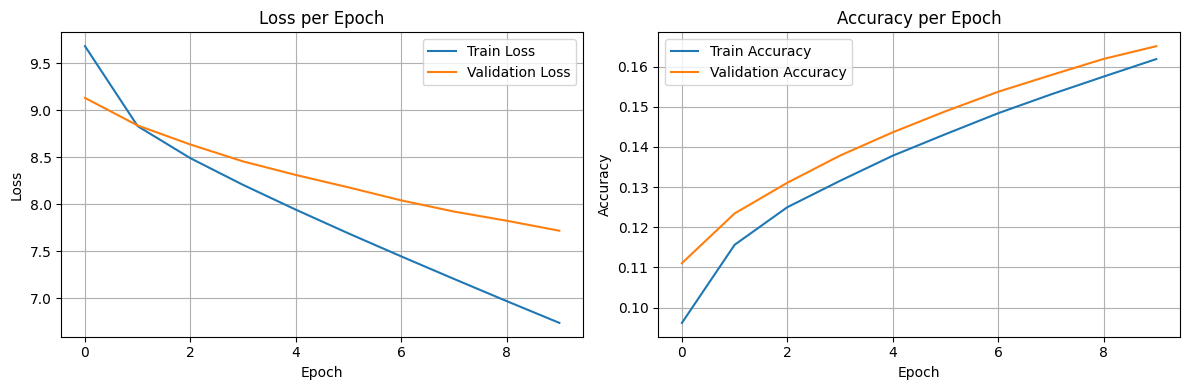

In [13]:
model = Transformer(
    src_vocab_size=len(en_tokenizer),
    tgt_vocab_size=len(fr_tokenizer),
    d_model=128,
    num_layers=2,
    num_heads=4,
    ff_hidden_dim=512,
    max_len=20
).to(device)

if hasattr(model, "gradient_checkpointing_enable"):
    model.gradient_checkpointing_enable()
    print("Gradient checkpointing enabled.")
else:
    print("This model does not support gradient_checkpointing_enable().")


optimizer = get_optimizer(model)
train(model, train_loader, val_loader, optimizer, loss_fn, fr_tokenizer, num_epochs=10)

In [ ]:
torch.save({
    'epoch': 10,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "transformer_checkpoint.pth")

## Step 13: Greedy Decoding Inference

Greedy decoding generates a translation by picking the most likely word at each step.
It stops if <eos> is generated or max_len is reached. Here we'll go through step by step to see
how our model is actually translating.

1. We put the model in evaluation mode. This make sures that dropout and gradient updates are turned off during inference.
2. We tokenize the input english sentence.
3. Then we start the ouput sequence. <sos> is the starting token for the French sentence. The decoder always starts with this.
4. And then we build up the output one token at a time. Each time, we feed the current sequence to the decoder and get the prediction for the next word.
5. The model outputs scores for every word in the vocabulary and we pick the one with the highest probability — this is “greedy decoding”.
6. When the model says the sentence is over <eos>, we stop generating further.

So, we start with <sos> and greedily build one word at a time by always picking the most likely next token — until it hits <eos>


In [15]:
def greedy_decode(model, src_sentence, src_tokenizer, tgt_tokenizer, max_len=20, weight_path=None):
    if weight_path:
        model.load_state_dict(torch.load(weight_path, map_location=device))
    model.eval()
    with torch.no_grad():
        src_ids = src_tokenizer.encode(src_sentence)
        src_tensor = torch.tensor([src_ids + [0]*(max_len - len(src_ids))]).to(device)

        tgt_ids = [tgt_tokenizer.word2idx['<sos>']]

        for _ in range(max_len):
            tgt_tensor = torch.tensor([tgt_ids + [0]*(max_len - len(tgt_ids))]).to(device)
            output = model(src_tensor, tgt_tensor)
            next_token_logits = output[0, len(tgt_ids)-1]
            next_token = torch.argmax(next_token_logits).item()
            if next_token == tgt_tokenizer.word2idx['<eos>']:
                break
            tgt_ids.append(next_token)

        return tgt_tokenizer.decode(tgt_ids[1:])

## Step 14: Translation Example

In [18]:
translation = greedy_decode(
    model,
    "God",
    en_tokenizer,
    fr_tokenizer,
    weight_path="transformer_weights.pth")

print("Tamil Translation:", translation)

Tamil Translation: தேவன்


## Step 15: Task BLEU Score calculation

In [19]:
from nltk.translate.bleu_score import corpus_bleu

predictions = []
references = []
max_len = 20
model.eval()
with torch.no_grad():
    for src, tgt_input, tgt_output in val_loader:
        src, tgt_input, tgt_output = src.to(device), tgt_input.to(device), tgt_output.to(device)
        
        # Process each sample in the batch
        for i in range(src.size(0)):
            src_ids = src[i].cpu().tolist()
            tgt_ids = tgt_output[i].cpu().tolist()
            # Convert token IDs to text (removing special tokens if needed)
            src_sentence = en_tokenizer.decode(src_ids)
            tgt_sentence = fr_tokenizer.decode(tgt_ids)
            
            # Generate model prediction using greedy decoding
            pred_sentence = greedy_decode(model, src_sentence, en_tokenizer, fr_tokenizer, max_len)
            
            # Tokenize for BLEU (word-level)
            pred_tokens = pred_sentence.strip().split()
            ref_tokens = tgt_sentence.strip().split()
            predictions.append(pred_tokens)
            references.append([ref_tokens])

bleu_score = corpus_bleu(references, predictions, weights=(0.25, 0.25, 0.25, 0.25))
print(f"Validation Corpus BLEU-4 Score: {bleu_score:.4f}")


Validation Corpus BLEU-4 Score: 0.0089


## Peer-review task:

Now we've built and trained a Transformer from scratch for English-to-French translation, done some traslations and compared it with google translate, we are satisfied that our model is working good.

What we can do next is to give some score to how well our model is doing. And that's what the bleu score is. So, basically, BLEU gives us a quick way to measure how close our model’s translations are to the correct ones.

### Task:
Implement a BLEU score evaluation for our model using the `nltk.translate.bleu_score` module.

REFERENCES

https://peterbloem.nl/blog/transformers

https://arxiv.org/abs/1706.03762

https://medium.com/@lidores98/inetuning-huggingface-facebook-bart-model-2c758472e340

https://medium.com/@ferlatti.aldo/fine-tuning-a-chat-summarizer-c18625bc817d

https://huggingface.co/spaces/evaluate-metric/rouge

https://huggingface.co/spaces/evaluate-metric/bleu

https://huggingface.co/spaces/evaluate-metric/bertscore

https://plainenglish.io/community/evaluating-nlp-models-a-comprehensive-guide-to-rouge-bleu-meteor-and-bertscore-metrics-d0f1b1

https://www.comet.com/site/blog/bertscore-for-llm-evaluation/